<center><h1>Hu_Yaqi_HW4</h1></center>
<br>
<br>

Name: Hu, Yaqi
<br>
Github Username: YaqiHu23
<br>
USC ID: 7191264555

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math
from itertools import cycle
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, LabelBinarizer
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_curve,roc_auc_score,RocCurveDisplay
from sklearn.naive_bayes import GaussianNB,MultinomialNB

Get the AReM Data Set

In [2]:
# Dataset folder
AReM_path = '../AReM/'

folder_name = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
header_name = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
def read_train_test(folder_name_f, data_path):
    test_datas = []
    train_datas = []

    test_path = data_path + folder_name_f + '/' + 'test'
    file_list = os.listdir(test_path)
    for fl_te in file_list:
        read_path = test_path + '/' + fl_te
        temp_test_data = pd.read_csv(read_path, delimiter=',', skiprows=5, header=None)
        # temp_test_data.columns = header_name
        test_datas.append(temp_test_data)

    train_path = data_path + folder_name_f + '/' + 'train'
    file_list = os.listdir(train_path)
    # print(file_list)
    for fl_tr in file_list:
        read_path = train_path + '/' + fl_tr
        temp_train_data = pd.read_csv(read_path, delimiter=',', skiprows=5, header=None)
        # temp_train_data.columns = header_name
        train_datas.append(temp_train_data)
    test_datas = np.array(test_datas)
    train_datas = np.array(train_datas)
    return test_datas, train_datas

### (b) Splitting Data

In [3]:
# ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
bending1_testdata, bending1_traindata = read_train_test(folder_name[0], AReM_path)
print(f'This is the {folder_name[0]} test and train shape: {bending1_testdata.shape}, {bending1_traindata.shape}')

print('--------------------------------------')

bending2_testdata, bending2_traindata = read_train_test(folder_name[1], AReM_path)
# print(f'This is how the dataset looks like:\n', bending2_testdata.head())
print(f'This is the {folder_name[1]} test and train shape: {bending2_testdata.shape}, {bending2_traindata.shape}')

print('--------------------------------------')

cycling_testdata, cycling_traindata = read_train_test(folder_name[2], AReM_path)
# print(f'This is how the dataset looks like:\n', cycling_testdata.head())
print(f'This is the {folder_name[2]} test and train shape: {cycling_testdata.shape}, {cycling_traindata.shape}')

print('--------------------------------------')

lying_testdata, lying_traindata = read_train_test(folder_name[3], AReM_path)
# print(f'This is how the dataset looks like:\n', lying_testdata.head())
print(f'This is the {folder_name[3]} test and train shape: {lying_testdata.shape}, {lying_traindata.shape}')

print('--------------------------------------')

sitting_testdata, sitting_traindata = read_train_test(folder_name[4], AReM_path)
# print(f'This is how the dataset looks like:\n', lying_testdata.head())
print(f'This is the {folder_name[4]} test and train shape: {sitting_testdata.shape}, {sitting_traindata.shape}')

print('--------------------------------------')

standing_testdata, standing_traindata = read_train_test(folder_name[5], AReM_path)
# print(f'This is how the dataset looks like:\n', lying_testdata.head())
print(f'This is the {folder_name[5]} test and train shape: {standing_testdata.shape}, {standing_traindata.shape}')

print('--------------------------------------')

walking_testdata, walking_traindata = read_train_test(folder_name[6], AReM_path)
# print(f'This is how the dataset looks like:\n', lying_testdata.head())
print(f'This is the {folder_name[6]} test and train shape: {walking_testdata.shape}, {walking_traindata.shape}')

This is the bending1 test and train shape: (2, 480, 7), (5, 480, 7)
--------------------------------------
This is the bending2 test and train shape: (2, 480, 7), (4, 480, 7)
--------------------------------------
This is the cycling test and train shape: (3, 480, 7), (12, 480, 7)
--------------------------------------
This is the lying test and train shape: (3, 480, 7), (12, 480, 7)
--------------------------------------
This is the sitting test and train shape: (3, 480, 7), (12, 480, 7)
--------------------------------------
This is the standing test and train shape: (3, 480, 7), (12, 480, 7)
--------------------------------------
This is the walking test and train shape: (3, 480, 7), (12, 480, 7)


In [4]:
# We need first read all instances in

instances = []

# Next we need to read all data from each folders, here we need define several paths
paths = ['../AReM/bending1/', '../AReM/bending2/', '../AReM/cycling/', '../AReM/lying/', '../AReM/sitting/', '../AReM/standing/', '../AReM/walking/']

# Next we read each data from test/train.
for pt in paths:
    test_path = pt + 'test/'
    test_list = os.listdir(test_path)
    for tn in test_list:
        read_path = test_path + tn
        temp_test_data = pd.read_csv(read_path, delimiter=',', skiprows=5, header=None)
        instances.append(temp_test_data)
    # print(test_path)
    train_path = pt + 'train/'
    train_list = os.listdir(train_path)
    for tn in train_list:
        read_path = train_path + tn
        temp_train_data = pd.read_csv(read_path, delimiter=',', skiprows=5, header=None)
        instances.append(temp_train_data)

instances = np.array(instances)
print('Total read instances: ', instances.shape)

Total read instances:  (88, 480, 7)


### (c) Feature Extraction

In [5]:
# Next we extract the features

Features = []

for ins in range(0, instances.shape[0]):
    # Iterate through all instance
    # Get the instance
    ins_deal = instances[ins]
    # print(ins_deal.shape)

    # Split the data
    time_series_deal = np.hsplit(ins_deal, 7)
    # print(len(time_series_deal))
    for ts in range(1, 7):
        ts_deal = time_series_deal[ts]
        # print(ts_deal)
        ts_deal = np.array(ts_deal)
        Features.append([ts_deal.min(), ts_deal.max(), ts_deal.mean(), np.median(ts_deal), ts_deal.std(), np.percentile(ts_deal, 25), np.percentile(ts_deal, 75)])

Features = np.array(Features)
# print(Features.shape)
Features_re = Features.reshape(88, 6, 7)
# print(Features_re)

In [6]:
header = ['Min1', 'Max1', 'Mean1', 'Median1', 'Standard deviation1', 'First quartile1', 'Third quartile1',\
                      'Min2', 'Max2', 'Mean2', 'Median2', 'Standard deviation2', 'First quartile2', 'Third quartile2',\
                      'Min3', 'Max3', 'Mean3', 'Median3', 'Standard deviation3', 'First quartile3', 'Third quartile3',\
                      'Min4', 'Max4', 'Mean4', 'Median4', 'Standard deviation4', 'First quartile4', 'Third quartile4',\
                      'Min5', 'Max5', 'Mean5', 'Median5', 'Standard deviation5', 'First quartile5', 'Third quartile5',\
                      'Min6', 'Max6', 'Mean6', 'Median6', 'Standard deviation6', 'First quartile6', 'Third quartile6']

ts_pd_p1 = pd.DataFrame(Features_re[:, 0, :])
ts_pd_p2 = pd.DataFrame(Features_re[:, 1, :])
ts_pd_p3 = pd.DataFrame(Features_re[:, 2, :])
ts_pd_p4 = pd.DataFrame(Features_re[:, 3, :])
ts_pd_p5 = pd.DataFrame(Features_re[:, 4, :])
ts_pd_p6 = pd.DataFrame(Features_re[:, 5, :])
# print(ts_pd_p1.shape)
print_ts_full = pd.concat([ts_pd_p1, ts_pd_p2, ts_pd_p3, ts_pd_p4, ts_pd_p5, ts_pd_p6], axis=1)
# print(print_ts_full.shape)
ts_full = pd.DataFrame(print_ts_full)
ts_full.index = (range(1, 89))
ts_full.columns = header
ts_full

,Min1,Max1,Mean1,Median1,Standard deviation1,First quartile1,Third quartile1,Min2,Max2,Mean2,...,Standard deviation5,First quartile5,Third quartile5,Min6,Max6,Mean6,Median6,Standard deviation6,First quartile6,Third quartile6
1,37.25,45.00,40.624792,40.500,1.475428,39.25,42.0000,0.0,1.30,0.358604,...,2.186168,33.0000,36.00,0.0,1.92,0.570583,0.430,0.582308,0.00,1.3000
2,38.00,45.67,42.812812,42.500,1.434054,42.00,43.6700,0.0,1.22,0.372437,...,1.993175,32.0000,34.50,0.0,3.11,0.571083,0.430,0.600383,0.00,1.3000
3,35.00,47.40,43.954500,44.330,1.557210,43.00,45.0000,0.0,1.70,0.426250,...,1.997520,35.3625,36.50,0.0,1.79,0.493292,0.430,0.512971,0.00,0.9400
4,33.00,47.75,42.179812,43.500,3.666840,39.15,45.0000,0.0,3.00,0.696042,...,3.845436,30.4575,36.33,0.0,2.18,0.613521,0.500,0.523771,0.00,1.0000
5,33.00,45.75,41.678063,41.750,2.241152,41.33,42.7500,0.0,2.83,0.535979,...,2.408514,28.4575,31.25,0.0,1.79,0.383292,0.430,0.388759,0.00,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,20.75,46.25,34.763333,35.290,4.737266,31.67,38.2500,0.0,12.68,4.223792,...,3.171372,14.2500,18.33,0.0,9.39,3.288271,3.270,1.645811,2.05,4.3050
85,21.50,51.00,34.935812,35.500,4.641102,32.00,38.0625,0.0,12.21,4.115750,...,3.188731,14.2375,18.25,0.0,10.21,3.280021,3.015,1.699145,2.12,4.5000
86,18.33,47.67,34.333042,34.750,4.943612,31.25,38.0000,0.0,12.48,4.396958,...,2.997366,13.7500,18.00,0.0,8.01,3.261583,2.980,1.615604,2.05,4.3200
87,18.33,45.75,34.599875,35.125,4.726858,31.50,38.0000,0.0,15.37,4.398833,...,2.902659,14.0000,18.25,0.0,8.86,3.289542,3.015,1.678418,2.12,4.2600


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [7]:
# As here we will use train set, I first concat each train set into one set.
# ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']

train_set_original = np.concatenate((bending1_traindata, bending2_traindata, cycling_traindata, lying_traindata, sitting_traindata, standing_traindata, walking_traindata))
test_set_original = np.concatenate((bending1_testdata, bending2_testdata, cycling_testdata, lying_testdata, sitting_testdata, standing_testdata, walking_testdata))

print(f'This is train & test set size:', train_set_original.shape, test_set_original.shape)

This is train & test set size: (69, 480, 7) (19, 480, 7)


##### Train Set features table

In [8]:
# Here I consider that we need to plot the trainset features information.
before_split_features = []
trainset = train_set_original.reshape(69*480, 7)
for ins in range(0, int(trainset.shape[0]/480)):
    ins_deal = trainset[ins*480:(ins+1)*480]
    time_series_deal = np.hsplit(ins_deal, 7)
    # print(len(time_series_deal))
    for ts in range(1, 7):
        ts_deal = time_series_deal[ts]
        ts_deal = np.array(ts_deal)
        before_split_features.append([ts_deal.min(), ts_deal.max(), ts_deal.mean(), np.median(ts_deal), ts_deal.std(), np.percentile(ts_deal, 25), np.percentile(ts_deal, 75)])
    # print(len(before_split_features))
before_split_features = np.array(before_split_features)
before_split_features = before_split_features.reshape(69, 6, -1)

ts1 = pd.DataFrame(before_split_features[:, 0, :])
ts2 = pd.DataFrame(before_split_features[:, 1, :])
ts3 = pd.DataFrame(before_split_features[:, 2, :])
ts4 = pd.DataFrame(before_split_features[:, 3, :])
ts5 = pd.DataFrame(before_split_features[:, 4, :])
ts6 = pd.DataFrame(before_split_features[:, 5, :])
# print(ts_pd_p1.shape)
print_ts = pd.concat([ts1, ts2, ts3, ts4, ts5, ts6], axis=1)
# print(print_ts_full.shape)
ts_full = pd.DataFrame(print_ts)
ts_full.index = (range(1, 70))
ts_full.columns = header
ts_full


,Min1,Max1,Mean1,Median1,Standard deviation1,First quartile1,Third quartile1,Min2,Max2,Mean2,...,Standard deviation5,First quartile5,Third quartile5,Min6,Max6,Mean6,Median6,Standard deviation6,First quartile6,Third quartile6
1,35.00,47.40,43.954500,44.330,1.557210,43.00,45.0000,0.0,1.70,0.426250,...,1.997520,35.3625,36.50,0.0,1.79,0.493292,0.430,0.512971,0.00,0.9400
2,33.00,47.75,42.179812,43.500,3.666840,39.15,45.0000,0.0,3.00,0.696042,...,3.845436,30.4575,36.33,0.0,2.18,0.613521,0.500,0.523771,0.00,1.0000
3,33.00,45.75,41.678063,41.750,2.241152,41.33,42.7500,0.0,2.83,0.535979,...,2.408514,28.4575,31.25,0.0,1.79,0.383292,0.430,0.388759,0.00,0.5000
4,37.00,48.00,43.454958,43.250,1.384653,42.50,45.0000,0.0,1.58,0.378083,...,2.486268,22.2500,24.00,0.0,5.26,0.679646,0.500,0.621885,0.43,0.8700
5,36.25,48.00,43.969125,44.500,1.616677,43.31,44.6700,0.0,1.50,0.413125,...,3.314843,20.5000,23.75,0.0,2.96,0.555312,0.490,0.487318,0.00,0.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,20.75,46.25,34.763333,35.290,4.737266,31.67,38.2500,0.0,12.68,4.223792,...,3.171372,14.2500,18.33,0.0,9.39,3.288271,3.270,1.645811,2.05,4.3050
66,21.50,51.00,34.935812,35.500,4.641102,32.00,38.0625,0.0,12.21,4.115750,...,3.188731,14.2375,18.25,0.0,10.21,3.280021,3.015,1.699145,2.12,4.5000
67,18.33,47.67,34.333042,34.750,4.943612,31.25,38.0000,0.0,12.48,4.396958,...,2.997366,13.7500,18.00,0.0,8.01,3.261583,2.980,1.615604,2.05,4.3200
68,18.33,45.75,34.599875,35.125,4.726858,31.50,38.0000,0.0,15.37,4.398833,...,2.902659,14.0000,18.25,0.0,8.86,3.289542,3.015,1.678418,2.12,4.2600


##### Scatter plots of 1, 2, and 6 of each instance in trainset
Here I choose (min, mean, max) at first, and I want to check the answer with others and find my bugs, so I change the pair to (mean, median, first quartile). It is not a big deal.

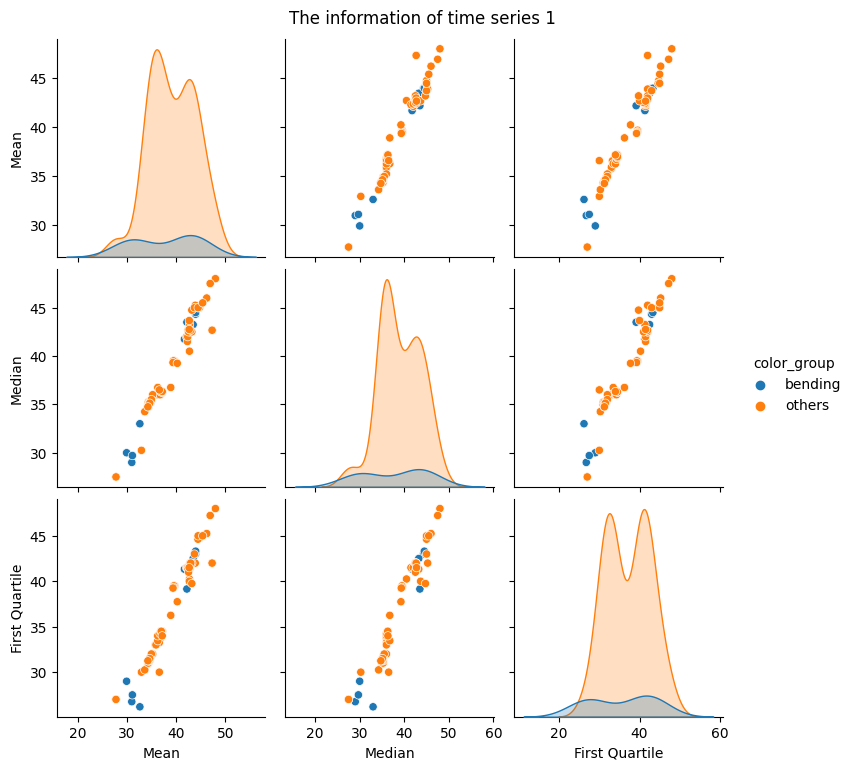

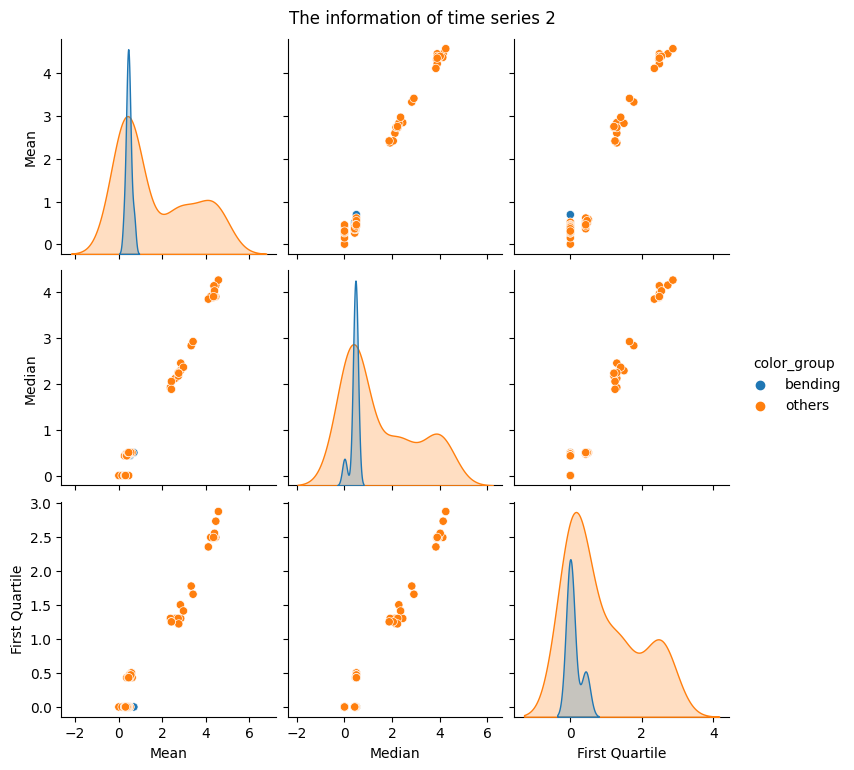

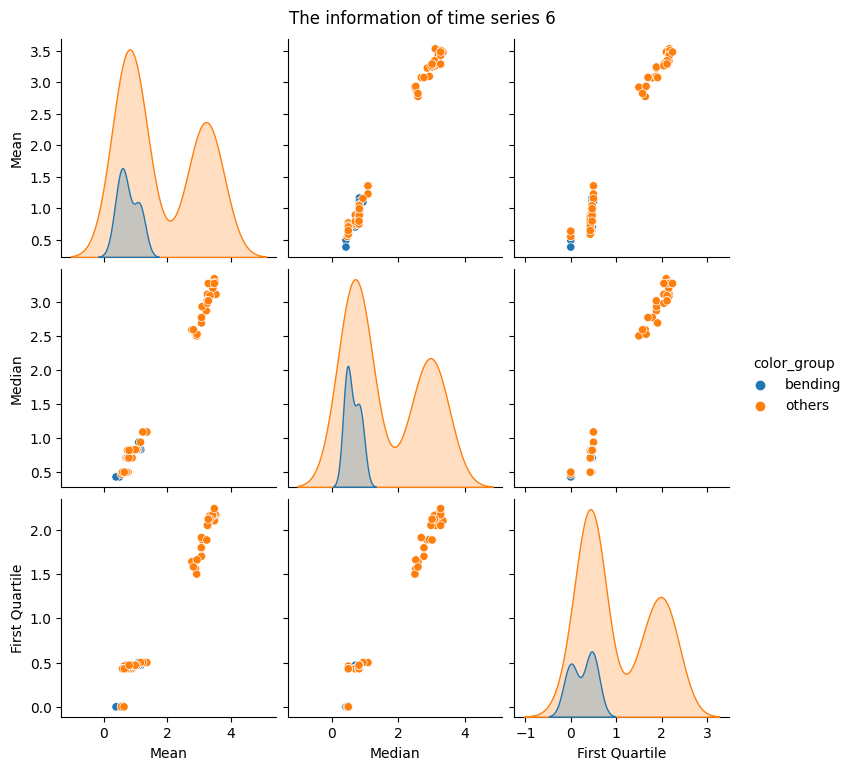

In [9]:
ts_train_1 = pd.DataFrame(before_split_features[:, 0, [2,3,5]])
# ts_train_1.columns = ['Min', 'Max', 'Mean']
ts_train_1.columns = ['Mean', 'Median', 'First Quartile']
ts_train_1['color_group'] = ['bending' if i<9 else 'others' for i in range(ts_train_1.shape[0])]
ts_train_2 = pd.DataFrame(before_split_features[:, 1, [2,3,5]])
ts_train_2.columns = ['Mean', 'Median', 'First Quartile']
ts_train_2['color_group'] = ['bending' if i<9 else 'others' for i in range(ts_train_2.shape[0])]
ts_train_3 = pd.DataFrame(before_split_features[:, 5, [2,3,5]])
ts_train_3.columns = ['Mean', 'Median', 'First Quartile']
ts_train_3['color_group'] = ['bending' if i<9 else 'others' for i in range(ts_train_3.shape[0])]

# Here I define a color group to plot different color

sns.pairplot(ts_train_1, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 1', y=1.02)
sns.pairplot(ts_train_2, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 2', y=1.02)
sns.pairplot(ts_train_3, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 6', y=1.02)
plt.show()

#### ii. Splitted Plots

##### Split Data from original raw data

This is new aranged splitted trainset: (69, 240, 14)


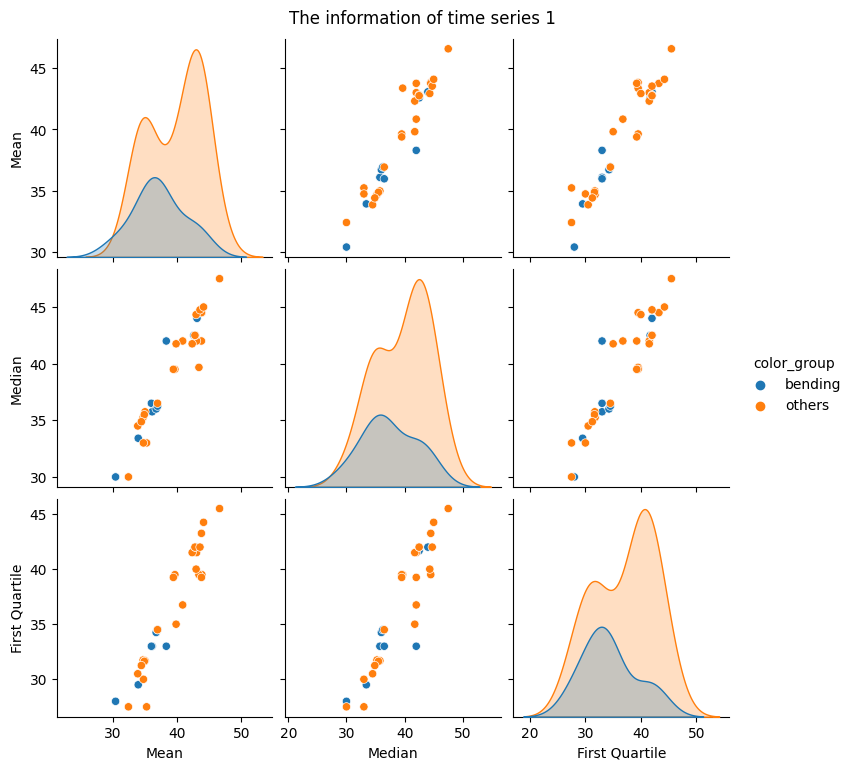

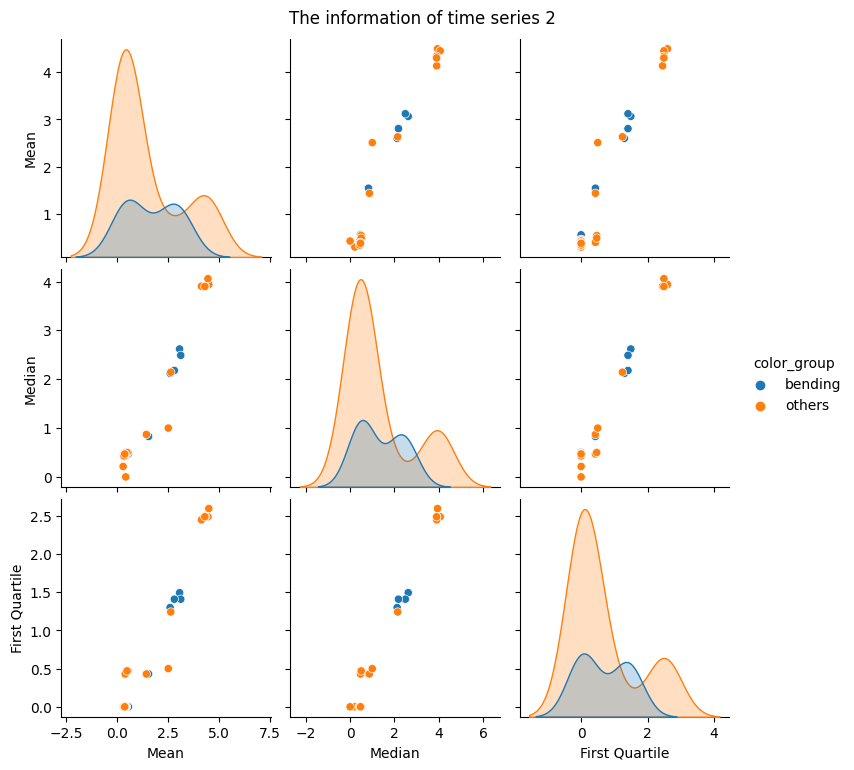

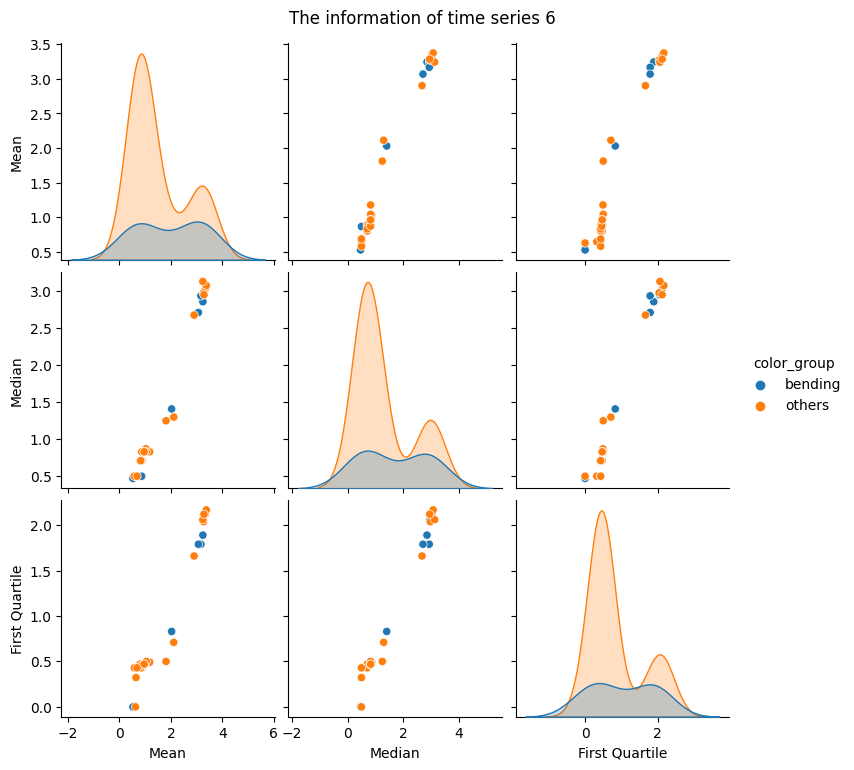

In [10]:
train_split_before = train_set_original.reshape(69, 240, 14)

print(f'This is new aranged splitted trainset:', train_split_before.shape)

train_split = train_split_before.reshape(69*240, 14)
after_split_features_1 = []

for ins in range(0, int(train_split.shape[0]/480)):
    ins_deal = train_split[ins*480:(ins+1)*480]
    time_series_deal = np.hsplit(ins_deal, 14)
    # print(len(time_series_deal))
    num = [i for i in range(1, 14) if i%7!=0]
    # print(num)
    for ts in num:
        ts_deal = time_series_deal[ts]
        ts_deal = np.array(ts_deal)
        after_split_features_1.append([ts_deal.min(), ts_deal.max(), ts_deal.mean(), np.median(ts_deal), ts_deal.std(), np.percentile(ts_deal, 25), np.percentile(ts_deal, 75)])
    # print(len(after_split_features_1))
after_split_features_1 = np.array(after_split_features_1)
after_split_features_1 = after_split_features_1.reshape(int(train_split.shape[0]/480), 12, -1)

# Next we plot them out

after_ts_train_1 = pd.DataFrame(after_split_features_1[:, 0, [2,3,5]])
after_ts_train_1.columns = ['Mean', 'Median', 'First Quartile']
after_ts_train_1['color_group'] = ['bending' if i<9 else 'others' for i in range(after_ts_train_1.shape[0])]
after_ts_train_2 = pd.DataFrame(after_split_features_1[:, 1, [2,3,5]])
after_ts_train_2.columns = ['Mean', 'Median', 'First Quartile']
after_ts_train_2['color_group'] = ['bending' if i<9 else 'others' for i in range(after_ts_train_2.shape[0])]
after_ts_train_3 = pd.DataFrame(after_split_features_1[:, 5, [2,3,5]])
after_ts_train_3.columns = ['Mean', 'Median', 'First Quartile']
after_ts_train_3['color_group'] = ['bending' if i<9 else 'others' for i in range(after_ts_train_3.shape[0])]

# Here I define a color group to plot different color

sns.pairplot(after_ts_train_1, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 1', y=1.02)
sns.pairplot(after_ts_train_2, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 2', y=1.02)
sns.pairplot(after_ts_train_3, hue='color_group', kind='scatter')
plt.suptitle('The information of time series 6', y=1.02)
plt.show()

##### Differeces after break each time series

It seems like the bendings span to the whole values, same as other features, compared with before breaking. \
Before breaking, the bending values only occupy small size of value range.

#### iii. Time Series Segments

##### Here is on interesting thing happened

At first, I applied the standardscaler()/Minmaxscaler() to the training data, and get some selected features and their p-values, all of them is near 1.\

\
After that, I removed the scaler, but will face the convergence problem. Then I make max_iter=1000 to fix the problem, but the trade-off is long training time. I get some new selected features (more than use scaler) and their p-values, all of them is NAN.\
\
It means that there is no statistic significant features. This problem may also caused by highly separation of the classes.

In [11]:
# Let we define a split function to do that, as iii also need to split time series into 1, 2, 3, ..., 20
# The original dataset size is (69, 480, 7)
def split_time_series(type, split_num, target):
    # we need to split 480 into 480, 240, 120, ...
    # and 7 will times to 14, 21, ...
    temp_split = target
    split_shape = target.shape
    # print(split_shape)
    # Next we split the data, according to the dataset, we will face the problem that sometimes cannot split into equally likely size
    # Here I throw some of the data to fix that problem
    flooring_shape = split_shape[1]//split_num
    # print(split_num*flooring_shape, split_shape[1]%split_num != 0)
    cut = split_num*flooring_shape
    if split_shape[1]%split_num != 0:
        temp_split = temp_split[:, :split_num*flooring_shape, :]
    # print(temp_split.shape)
    if type == 'train':
        first_d = 69
    else:
        first_d = 19
    splited_data = temp_split.reshape(first_d, flooring_shape, 7*split_num)
    return splited_data


def extract_features(type, l, dataset):
    features = []
    before_processing = split_time_series(type, l, dataset)
    if type == 'train':
        first_d = 69
    else:
        first_d = 19
    # print(before_processing.shape)
    # before_processing = before_processing.reshape(before_processing.shape[0]*before_processing.shape[1], -1)
    for ins in range(first_d):
        ins_deal = before_processing[ins, :, :]
        time_series_deal = np.hsplit(ins_deal, 7*l)
        num = [i for i in range(1, 7*l) if i%7!=0]
        # print(f'This is num', num)
        for ts in num:
            ts_deal = time_series_deal[ts]
            ts_deal = np.array(ts_deal)
            # features.append([ts_deal.min(), ts_deal.max(), ts_deal.mean(), np.median(ts_deal), ts_deal.std(), np.percentile(ts_deal, 25), np.percentile(ts_deal, 75)])
            # features.append([ts_deal.min(), ts_deal.max(), ts_deal.mean()])
            features.append([ts_deal.mean(), np.median(ts_deal), np.percentile(ts_deal, 25)])
    features = np.array(features)
    # print(features.shape)
    
    features = features.reshape(first_d, 6*l, -1)
    features = features.reshape(-1, features.shape[1]*features.shape[2])
    # print(features.shape)

    return features

def split_dataset(type, split_num, dataset):
    split = []
    for l in range(1, split_num+1):
        features = []
        features = extract_features(type, l ,dataset)
        split.append(pd.DataFrame(features))
    # print(len(split))
    return split




In [12]:
# Let we get the training data
final_dataset = split_dataset('train', 20, train_set_original)

for i in range(20):
    # print(final_dataset)
    final_dataset[i]['label'] = 0
    final_dataset[i].loc[:8, 'label'] = 1
    # print(final_dataset[i]['label'])


In [13]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Fcuntions for training the model
def train_logicwithRFECV(train_data, num):
    accuracy_scorelist = []
    CV_scorelist = []
    models_RFECV = []
    selector_RFECV = []
    for i in range(num):
        train_each = train_data[i]
        # train_each = scaler.fit_transform(train_each)
        # train_each = pd.DataFrame(train_each)
        # train_each.columns = header
        # train_each.index = range(1, 70)

        
        # print(train_each)
        train_X = scaler.fit_transform(train_each.iloc[:, :-1])
        
        # train_X = train_each.iloc[:, :-1]
        # print(train_X)
        train_y = train_each.iloc[:, -1]

        clf = LogisticRegression(solver='lbfgs',random_state=1729,C=float('inf'), max_iter=1000)
        selector = RFECV(estimator=clf, step=1, cv=5)
        selector=selector.fit(train_X, train_y)

        CV_mean = cross_val_score(selector,train_X,train_y,cv=5).mean()
        acc_score = selector.score(train_X, train_y)
        CV_scorelist.append(CV_mean)
        accuracy_scorelist.append(acc_score)
        models_RFECV.append(clf)
        selector_RFECV.append(selector)
    return models_RFECV, CV_scorelist, accuracy_scorelist, selector_RFECV



In [14]:
# Next we train the model

logic_models, CV_scores, accuracy_scores, selector_RFECV = train_logicwithRFECV(final_dataset, 20)

In [15]:
# Find the best pair of (l, p)
# We first find the best cv_scores
best_CV = max(CV_scores)

# After we find that, we find which model achieve that score
# print(CV_scores)
model_best = [i for i, x in enumerate(CV_scores) if x == best_CV]


# If we find more than one model achieve that, then we select the minimum features one

best_features = float('inf')
best_index = 0
for i in model_best:
    if selector_RFECV[i].transform(final_dataset[i].iloc[:, :-1]).shape[1] < best_features:
        best_features = selector_RFECV[i].transform(final_dataset[i].iloc[:, :-1]).shape[1] 
        best_index = i

print(f'Here is the best pair of (l, p) I find in my experiment: ({best_index+1}, {best_features})')
print(f'And the coressponding Cross Validation error is: {best_CV}')

Here is the best pair of (l, p) I find in my experiment: (10, 5)
And the coressponding Cross Validation error is: 0.9274725274725275


##### Right way to perform cross-validation

Like mentioned in textbook and slides, the right way of doing cross-validation is performing it before find the subsets of the predictors, that is, dividing the trainset before find the subsets. Then training the model, using the selected features.\
Here RFECV() Helps us to do that.\
\
And the wrong way is find a subset of the predictors first, by the whole training set, and then select one subset of the features, then apply cross-validation and use it to train model.

#### iv. Confusion Matrix

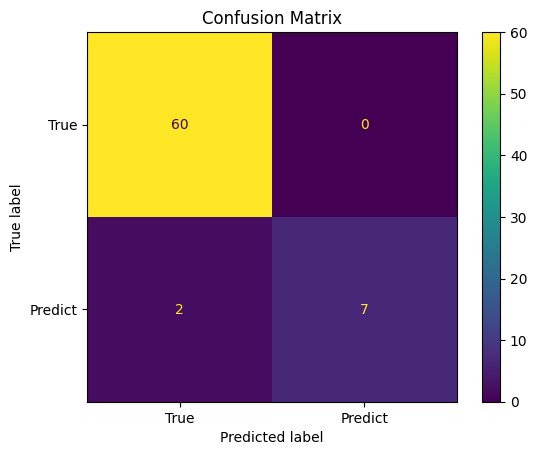

The ROC curve I Got:


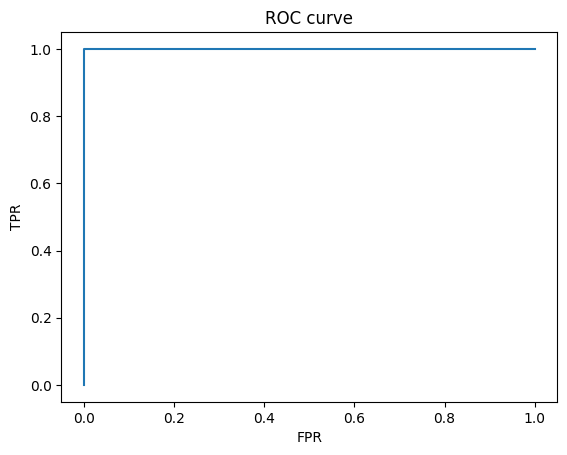

The AUC of the ROC curve image is 1.0


In [16]:
CM_matrix_data = final_dataset[best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,selector_RFECV[best_index].predict(final_dataset[best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['True', 'Predict']).plot()
plt.title('Confusion Matrix')
plt.show()

print('The ROC curve I Got:')
curve_p = selector_RFECV[best_index].predict_proba(final_dataset[best_index].drop('label', axis=1))[:, 1]
fpr, tpr, thresholds=roc_curve(CM_matrix_data, curve_p)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
auc_score = roc_auc_score(CM_matrix_data, curve_p)
print('The AUC of the ROC curve image is', auc_score)

##### Logistic regression features and their P-values

In [17]:
feature_selected = list(selector_RFECV[best_index].get_feature_names_out(final_dataset[best_index].drop('label', axis=1).columns))
print(feature_selected)
# Let we run a statsmodel for best model to get its p-value
removed_trainset = final_dataset[best_index][feature_selected]
# removed_trainset = scaler.fit_transform(removed_trainset)
logit_model = sm.Logit(final_dataset[best_index]['label'], sm.add_constant(removed_trainset))

fitted_model = logit_model.fit(method='bfgs')

result = pd.DataFrame([])
result['parameters'] = fitted_model.params
result['P-values'] = fitted_model.pvalues
result

[12, 18, 98, 151, 173]
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29


,parameters,P-values
const,-0.548662,1.000000
12,16.616510,0.999667
18,-7.070215,0.999903
98,11.410517,0.999939
151,-10.954072,0.999882
173,-28.109152,0.999741


#### v. Test Classifier

In [18]:
# Break the testset
final_test = split_dataset('test', 20, test_set_original)

# There are 4 csv bending 1&2 in testset
for i in range(20):
    final_test[i]['label'] = 0
    final_test[i].loc[:3, 'label'] = 1
    

In [19]:
best_testset = final_test[best_index]
test_X = best_testset.drop('label', axis=1)
test_X = scaler.fit_transform(test_X)
test_y = best_testset['label']

best_test_score = selector_RFECV[best_index].score(test_X,test_y)
print(f'Here is the best test score for 20 models: {best_test_score}')
print(f'Compare of the best test score and CV score: {best_test_score, best_CV}')

Here is the best test score for 20 models: 1.0
Compare of the best test score and CV score: (1.0, 0.9274725274725275)


##### Compare of test score and cross-validation score

The test score is higher than cross-validation score, as cross-validation only use 80% of the training data (5-fold CV), and the model should be underfitting.

#### vi. Separation

Yes. The instability is caused by highly separated data. It is kind of well-separated.\
The sm.logit also said that the Complete Separation: The results show that there iscomplete separation or perfect prediction. In this case the Maximum Likelihood Estimator does not exist and the parameters are not identified.

#### vii. Imbalance

Yes, we can see the imbalanced class from confusion matrices. Here I use the case-control samlping method to do the work. I'm not sure it is right or not.

In [20]:
# Let we implement the case-control sampling， make the final_dataset (trainset) balanced
# The final set is 20 dimentions, each dimention contains one trainset for a l value, from 1 to 20
def make_balance(dataset):
    new_dataset = []
    for i in range(20):
        l_set = dataset[i]
        cases = l_set[l_set['label'] == 1]
        controls = l_set[l_set['label'] == 0]

        # Let we make these approximate equal size
        n_samples = min(len(cases), len(controls))
        cases_sample = cases.sample(n_samples)
        controls_sample = controls.sample(n_samples)

        result = pd.concat([cases_sample, controls_sample])
        # print(result.shape)
        new_dataset.append(result)
    # new_dataset = np.array(new_dataset)
    return new_dataset

In [21]:
# Let we retrain the models
balanced_trainset = make_balance(final_dataset)
balanced_testset = make_balance(final_test)
# print(len(balanced_trainset[0]))
# print(balanced_testset.shape)
ba_models_logit, ba_CV_scores, ba_acc_scores, ba_selector = train_logicwithRFECV(balanced_trainset, 20)

In [22]:
# Again, find the best (l, p) pair

ba_best_CV = max(ba_CV_scores)

ba_model_best = [i for i, x in enumerate(ba_CV_scores) if x == ba_best_CV]


# If we find more than one model achieve that, then we select the minimum features one

ba_best_features = float('inf')
ba_best_index = 0
for i in ba_model_best:
    if ba_selector[i].transform(balanced_trainset[i].iloc[:, :-1]).shape[1] < best_features:
        ba_best_features = ba_selector[i].transform(balanced_trainset[i].iloc[:, :-1]).shape[1]
        ba_best_index = i

print(f'Here is the best pair of (l, p) I find in my experiment: ({ba_best_index+1}, {ba_best_features})')
print(f'And the coressponding Cross Validation error is: {ba_best_CV}')

Here is the best pair of (l, p) I find in my experiment: (1, inf)
And the coressponding Cross Validation error is: 1.0


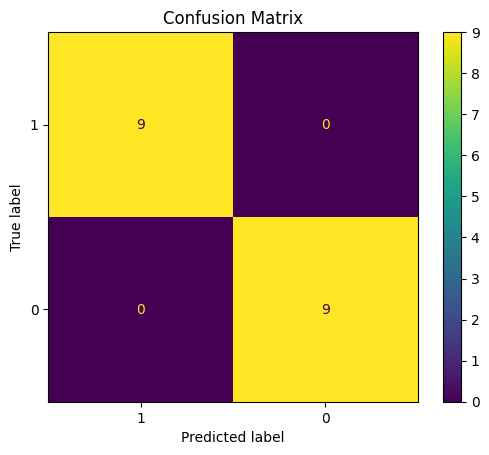

The ROC curve I Got:


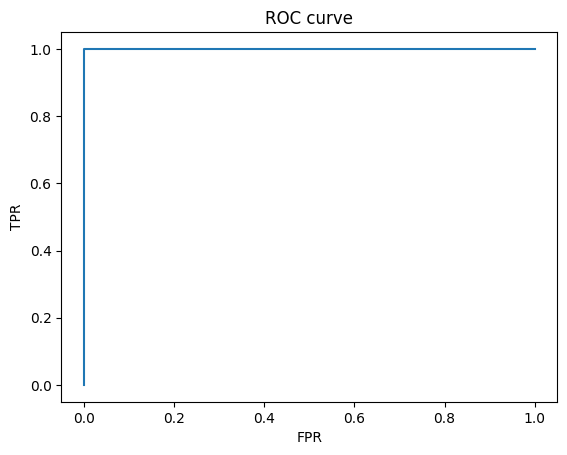

The AUC of the ROC curve image is 1.0


In [23]:
CM_matrix_data = balanced_trainset[ba_best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,ba_selector[best_index].predict(balanced_trainset[best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['1', '0']).plot()
plt.title('Confusion Matrix')
plt.show()

print('The ROC curve I Got:')
curve_p = ba_selector[best_index].predict_proba(balanced_trainset[best_index].drop('label', axis=1))[:, 1]
fpr, tpr, thresholds=roc_curve(CM_matrix_data, curve_p)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
auc_score = roc_auc_score(CM_matrix_data, curve_p)
print('The AUC of the ROC curve image is', auc_score)

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

Let we define a new functin to train the model

In [24]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()
# Fcuntions for training the model
def train_logicwithl1(train_data, num):
    accuracy_scorelist = []
    CV_scorelist = []
    models_l1 = []
    selector_l1 = []
    for i in range(num):
        train_each = train_data[i]
      
        # train_X = scaler.fit_transform(train_each.iloc[:, :-1])
        train_X = train_each.iloc[:, :-1]
        train_y = train_each.iloc[:, -1]

        clf = LogisticRegression(solver='liblinear',random_state=1729, penalty='l1', max_iter=1000)
        selector = RFECV(estimator=clf, step=1, cv=5)
        selector=selector.fit(train_X, train_y)

        CV_mean = cross_val_score(selector,train_X,train_y,cv=5).mean()
        acc_score = selector.score(train_X, train_y)
        CV_scorelist.append(CV_mean)
        accuracy_scorelist.append(acc_score)
        models_l1.append(clf)
        selector_l1.append(selector)
    return models_l1, CV_scorelist, accuracy_scorelist, selector_l1


In [25]:
logicl1_models, l1_CV_scores, l1_acc_scores, l1_selector = train_logicwithl1(final_dataset, 20)

In [26]:
l1_best_CV = max(l1_CV_scores)

l1_model_best = [i for i, x in enumerate(l1_CV_scores) if x == l1_best_CV]

l1_best_features = float('inf')
l1_best_index = 0
for i in l1_model_best:
    if l1_selector[i].transform(final_dataset[i].iloc[:, :-1]).shape[1] < best_features:
        l1_best_features = l1_selector[i].transform(final_dataset[i].iloc[:, :-1]).shape[1] 
        l1_best_index = i

print(f'Here is the best pair of (l, p) I find in my experiment: ({l1_best_index+1}, {l1_best_features})')
print(f'And the coressponding Cross Validation error is: {l1_best_CV}')

Here is the best pair of (l, p) I find in my experiment: (5, 3)
And the coressponding Cross Validation error is: 0.9703296703296704


In [27]:
l1_best_testset = final_test[l1_best_index]
l1_test_X = l1_best_testset.drop('label', axis=1)
l1_test_y = l1_best_testset['label']

best_test_l1score = l1_selector[l1_best_index].score(l1_test_X, l1_test_y)
print(f'Here is the best test score for 20 models: {best_test_l1score}')
print(f'Compare of the best test score and CV score: {best_test_l1score, l1_best_CV}')

Here is the best test score for 20 models: 1.0
Compare of the best test score and CV score: (1.0, 0.9703296703296704)


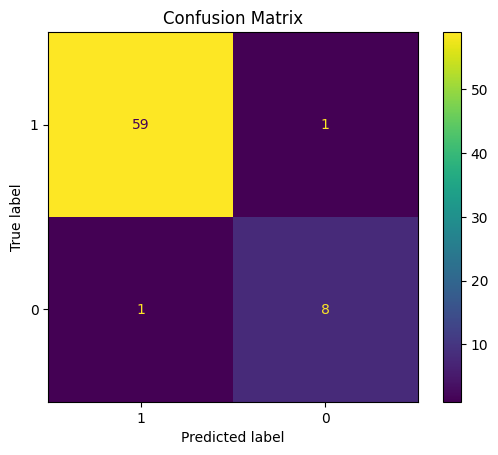

The ROC curve I Got:


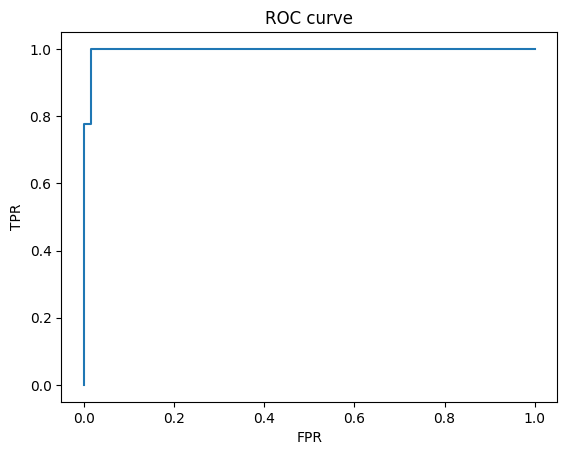

The AUC of the ROC curve image is 0.9962962962962963


In [28]:
CM_matrix_data = final_dataset[l1_best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,l1_selector[l1_best_index].predict(final_dataset[l1_best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['1', '0']).plot()
plt.title('Confusion Matrix')
plt.show()

print('The ROC curve I Got:')
curve_p = l1_selector[l1_best_index].predict_proba(final_dataset[l1_best_index].drop('label', axis=1))[:, 1]
fpr, tpr, thresholds=roc_curve(CM_matrix_data, curve_p)
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
auc_score = roc_auc_score(CM_matrix_data, curve_p)
print('The AUC of the ROC curve image is', auc_score)

#### ii. Comparison

The perform of using Z1-penalized and selection using p-value or backward selection are same. \
But the Z1-penalized one is easier to implement, as it only needs add one term in training step. Rather than calculate/get P-value.

### (c) Multi-class Classification (The Realistic Case)

Here I also use (mean, median, first quartile) pairs

#### i. Time Series Segments

Here I manually assign the label to different classes, like first 9 is bending, then 12 to cycling like this.

In [29]:
multi_trainset = split_dataset('train', 20, train_set_original)

for i in range(20):
    multi_trainset[i]['label'] = 0
    multi_trainset[i].loc[:9, 'label'] = 'bending'
    multi_trainset[i].loc[10:21, 'label'] = 'cycling'
    multi_trainset[i].loc[22:33, 'label'] = 'lying'
    multi_trainset[i].loc[34:45, 'label'] = 'sitting'
    multi_trainset[i].loc[46:57, 'label'] = 'standing'
    multi_trainset[i].loc[58:69, 'label'] = 'walking'

multi_testset = split_dataset('test', 20, test_set_original)
for i in range(20):
    multi_testset[i]['label'] = 0
    multi_testset[i].loc[:4, 'label'] = 'bending'
    multi_testset[i].loc[5:7, 'label'] = 'cycling'
    multi_testset[i].loc[8:10, 'label'] = 'lying'
    multi_testset[i].loc[11:13, 'label'] = 'sitting'
    multi_testset[i].loc[14:16, 'label'] = 'standing'
    multi_testset[i].loc[17:19, 'label'] = 'walking'

In [30]:
# Here we only need the same model to fit like above, the only different is we have multiclass now

multi_models, multi_CV, multi_acc, multi_selector = train_logicwithl1(multi_trainset, 20)

In [31]:
# Almost the same work like above
multi_best_CV = max(multi_CV)

multi_model_best = [i for i, x in enumerate(multi_CV) if x == multi_best_CV]

multi_best_features = float('inf')
multi_best_index = 0
for i in l1_model_best:
    if multi_selector[i].transform(multi_trainset[i].iloc[:, :-1]).shape[1] < best_features:
        multi_best_features = multi_selector[i].transform(multi_trainset[i].iloc[:, :-1]).shape[1]
        multi_best_index = i

print(f'Here is the best l I find in my experiment: {multi_best_index+1}')
print(f'And the coressponding Cross Validation error is: {multi_best_CV}')


Here is the best l I find in my experiment: 1
And the coressponding Cross Validation error is: 0.7494505494505495


In [32]:
multi_best_testset = multi_testset[multi_best_index]
multi_test_X = multi_best_testset.drop('label', axis=1)
multi_test_y = multi_best_testset['label']

best_test_multiscore = multi_selector[multi_best_index].score(multi_test_X, multi_test_y)
print(f'Here is the best test score for 20 models: {best_test_multiscore}')
print(f'Compare of the best test score and CV score: {best_test_multiscore, multi_best_CV}')

Here is the best test score for 20 models: 0.7368421052631579
Compare of the best test score and CV score: (0.7368421052631579, 0.7494505494505495)


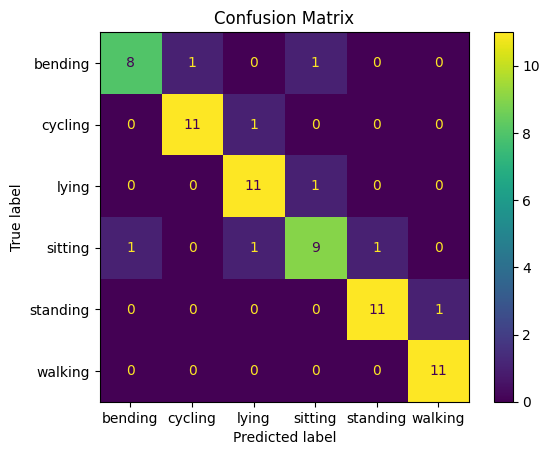

In [33]:
CM_matrix_data = multi_trainset[multi_best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,multi_selector[multi_best_index].predict(multi_trainset[multi_best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=multi_selector[multi_best_index].classes_).plot()
plt.title('Confusion Matrix')
plt.show()

##### For ROC of multi-classes, we cannot use the same method, but I modified the example provided by sklearn.
The method is called one vs rest method, which plot all ROC at one image.

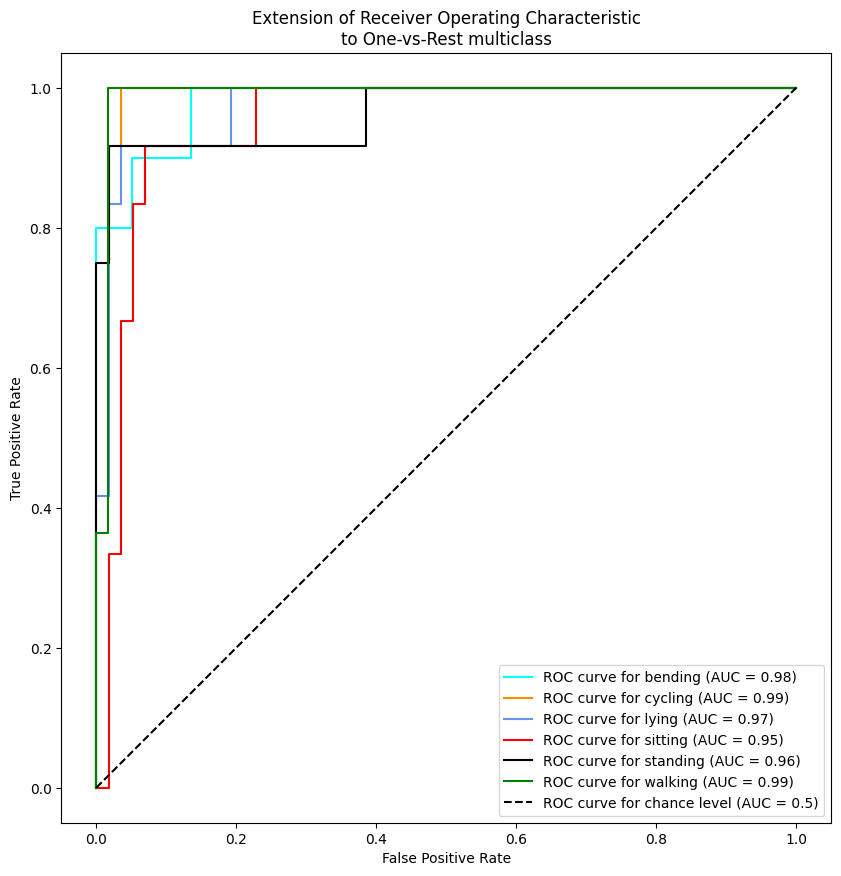

In [34]:
y_score = multi_selector[multi_best_index].predict_proba(multi_trainset[multi_best_index].drop('label', axis=1))

label_binarizer = LabelBinarizer().fit(multi_trainset[multi_best_index]['label'])
y_onehot_test = label_binarizer.transform(multi_trainset[multi_best_index]['label'])

target_names=np.unique(multi_trainset[multi_best_index]['label'])
n_classes=len(target_names)

fig, ax = plt.subplots(figsize=(10, 10))

colors = cycle(["aqua", "darkorange", "cornflowerblue",'red','black','green','yellow'])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

#### ii. Naive Bayes

##### Naive Bayes with Gaussian 

In [35]:
# Let we define new functions for Gaussian and multinomial priors

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# Fcuntions for training the model
def train_gu_naive(train_data, num):
    accuracy_scorelist = []
    CV_scorelist = []
    models_gu = []
    
    for i in range(num):
        train_each = train_data[i]
        
        # train_X = scaler.fit_transform(train_each.iloc[:, :-1])
        train_X = train_each.iloc[:, :-1]
        train_y = train_each.iloc[:, -1]

        GNB = GaussianNB()

        gu_model = GridSearchCV(GNB,param_grid={},cv=5)
        clf = gu_model.fit(train_X, train_y)

        CV_mean = cross_val_score(clf,train_X,train_y,cv=5).mean()
        acc_score = clf.score(train_X, train_y)
        CV_scorelist.append(CV_mean)
        accuracy_scorelist.append(acc_score)
        models_gu.append(clf)
    return models_gu, CV_scorelist, accuracy_scorelist

In [36]:
gu_models, gu_CV, gu_acc = train_gu_naive(multi_trainset, 20)

In [37]:
best_gu_CV = max(gu_CV)

gu_model_best = [i for i, x in enumerate(gu_CV) if x == best_gu_CV]
gu_best_index = gu_model_best[0]
# print(gu_best_index)

print(f'Here is the best l I find in my experiment: {gu_model_best[0]+1}')
print(f'And the coressponding Cross Validation error is: {best_gu_CV}')

Here is the best l I find in my experiment: 20
And the coressponding Cross Validation error is: 0.6791208791208792


In [38]:
gu_best_testset = multi_testset[gu_best_index]
gu_test_X = gu_best_testset.drop('label', axis=1)
gu_test_y = gu_best_testset['label']

gu_test_score = gu_models[gu_best_index].score(gu_test_X, gu_test_y)
print(f'The accuracy score of the Naive Bayes rule with Gaussian: {gu_test_score}')

The accuracy score of the Naive Bayes rule with Gaussian: 0.6842105263157895


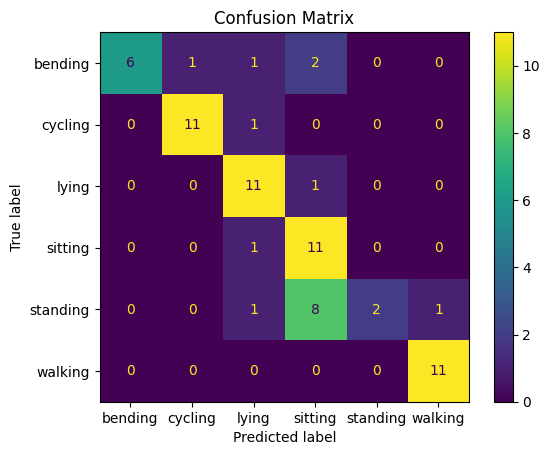

In [39]:
CM_matrix_data = multi_trainset[gu_best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,gu_models[gu_best_index].predict(multi_trainset[gu_best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gu_models[gu_best_index].classes_).plot()
plt.title('Confusion Matrix')
plt.show()

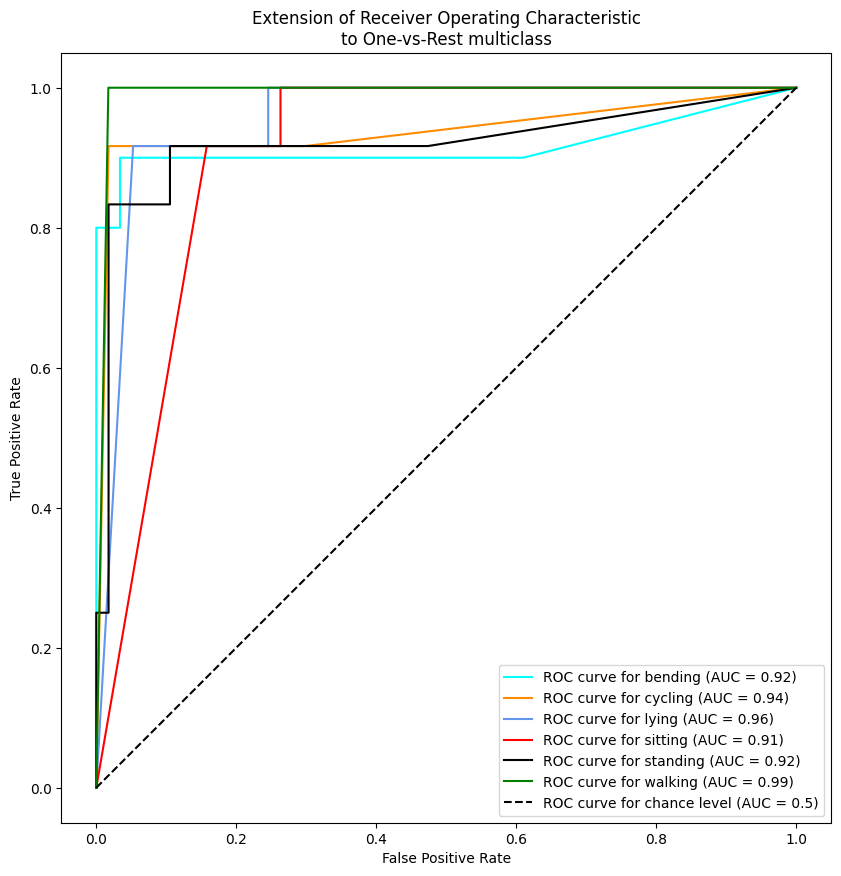

In [40]:
y_score = gu_models[gu_best_index].predict_proba(multi_trainset[gu_best_index].drop('label', axis=1))

label_binarizer = LabelBinarizer().fit(multi_trainset[gu_best_index]['label'])
y_onehot_test = label_binarizer.transform(multi_trainset[gu_best_index]['label'])

target_names=np.unique(multi_trainset[gu_best_index]['label'])
n_classes=len(target_names)

fig, ax = plt.subplots(figsize=(10, 10))

colors = cycle(["aqua", "darkorange", "cornflowerblue",'red','black','green','yellow'])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

##### Naive Bayes with Multinomial priors

In [41]:
# scaler = StandardScaler()
# scaler = MinMaxScaler()

# Fcuntions for training the model
def train_mb_naive(train_data, num):
    accuracy_scorelist = []
    CV_scorelist = []
    models_gu = []
    
    for i in range(num):
        train_each = train_data[i]
        
        # train_X = scaler.fit_transform(train_each.iloc[:, :-1])
        train_X = train_each.iloc[:, :-1]
        train_y = train_each.iloc[:, -1]

        MNB = MultinomialNB()

        clf = GridSearchCV(MNB,param_grid={},cv=5)
        clf = clf.fit(train_X, train_y)

        CV_mean = cross_val_score(clf,train_X,train_y,cv=5).mean()
        acc_score = clf.score(train_X, train_y)
        CV_scorelist.append(CV_mean)
        accuracy_scorelist.append(acc_score)
        models_gu.append(clf)
    return models_gu, CV_scorelist, accuracy_scorelist

In [42]:
mb_models, mb_CV, mb_acc = train_mb_naive(multi_trainset, 20)

In [43]:
best_mb_CV = max(mb_CV)

mb_model_best = [i for i, x in enumerate(mb_CV) if x == best_mb_CV]

mb_best_index = mb_model_best[0]

print(f'Here is the best l I find in my experiment: {mb_best_index+1}')
print(f'And the coressponding Cross Validation error is: {best_mb_CV}')

Here is the best l I find in my experiment: 1
And the coressponding Cross Validation error is: 0.6626373626373627


In [44]:
mb_best_testset = multi_testset[mb_best_index]
mb_test_X = mb_best_testset.drop('label', axis=1)
mb_test_y = mb_best_testset['label']

mb_test_score = mb_models[mb_best_index].score(mb_test_X, mb_test_y)
print(f'The accuracy score of the Naive Bayes rule with multinomial: {mb_test_score}')

The accuracy score of the Naive Bayes rule with multinomial: 0.631578947368421


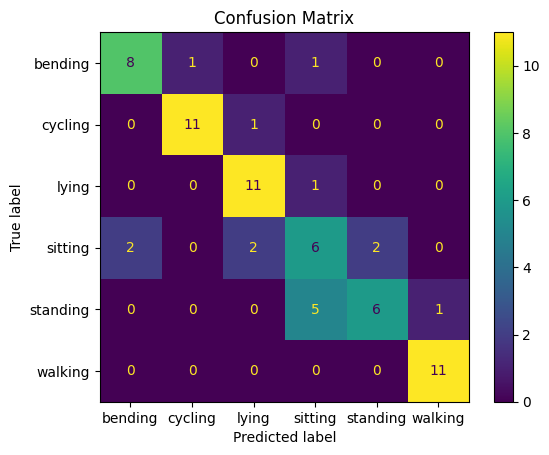

In [45]:
CM_matrix_data = multi_trainset[mb_best_index].iloc[:, -1]

cm = confusion_matrix(CM_matrix_data,mb_models[mb_best_index].predict(multi_trainset[mb_best_index].drop('label', axis=1)))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=mb_models[mb_best_index].classes_).plot()
plt.title('Confusion Matrix')
plt.show()

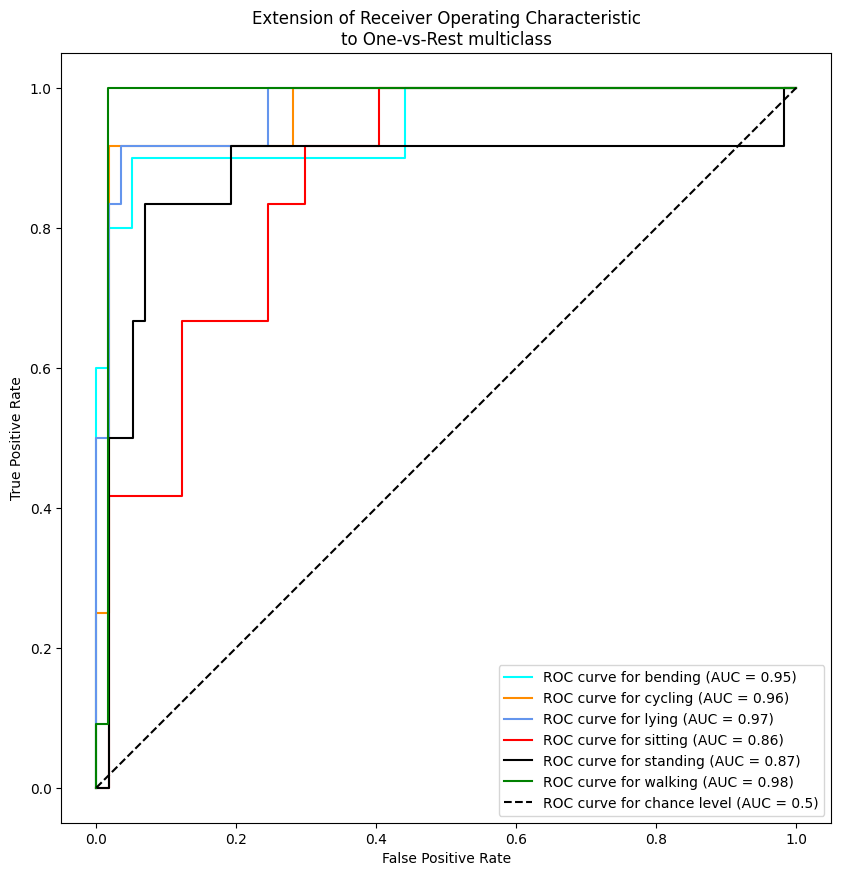

In [46]:
y_score = mb_models[mb_best_index].predict_proba(multi_trainset[mb_best_index].drop('label', axis=1))

label_binarizer = LabelBinarizer().fit(multi_trainset[mb_best_index]['label'])
y_onehot_test = label_binarizer.transform(multi_trainset[mb_best_index]['label'])

target_names=np.unique(multi_trainset[mb_best_index]['label'])
n_classes=len(target_names)

fig, ax = plt.subplots(figsize=(10, 10))

colors = cycle(["aqua", "darkorange", "cornflowerblue",'red','black','green','yellow'])

for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

Naive Bayes's classifier with Gaussian performance is little better than Naive Bayes's classifier with multinomial.

#### ii. Comparison

The Z1-penalized multinomial regression model performed best (test score) on this problem, which test score is  0.7368. \
And Naive Bayes's classifier with Gaussian erformance (test score) on this problem is test_score = 0.68421. \
Naive Bayes's classifier with Multinomial erformance (test score) on this problem is test_score = 0.6316.

Z1-penalized multinomial regression model performed best.

## 3. ISLR 4.8.3

In this problem, the data in each class follow the Gaussian distribution $ X \sim N(\mu_k, \sigma^2_k) $,  however, each class has different $\sigma_k$.

So the $p_k(x)$ will become: $$p_k(x) = \frac{\pi_k\frac{1}{\sqrt{2\pi}\sigma_k}exp(-\frac{1}{2\sigma_k^2}(x-\mu_k)^2)}{\sum_{l=1}^K \pi_l\frac{1}{\sqrt{2\pi}\sigma_l}exp(-\frac{1}{2\sigma_l^2}(x-\mu_l)^2)}$$

Take a log of the function, we get: $$ log\pi_k + log\frac{1}{\sqrt{2\pi}\sigma_k}-\frac{(x-\mu_k)^2}{2\sigma_k^2}$$

Obviously, we can find $$\delta_k(x) = argmax \quad logp(x) = log\pi_k-log\sigma_k-\frac{1}{2}\frac{(x-\mu_k)^2}{\sigma_k^2}$$
$$\delta_k(x) = argmax \quad logp(x) = log\pi_k-log\sigma_k-\frac{1}{2}(\frac{x^2}{\sigma_k^2}-\frac{2x\mu_k}{\sigma_k^2}+\frac{\mu_k^2}{\sigma_k^2})$$

if All the sigma is equal, that is $\sigma_1=\sigma_2=...$, then $\frac{x^2}{\sigma_k^2}$ will be cancelled, as sigma is a $x^2$ function.\
But here, as they are different, we cannot do that.

## 4. ISLR 4.8.7

Assume Yes = 1 and No = 0 \
The Information we have: $\mu_1=10$,  $\mu_0 = 0$,  $\sigma_1^2=\sigma_0^2=36$ \
$\pi_1=0.8, \pi_0=0.2$. \
X follows normal distribution, which function is: $$f(x)=\frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

To calculate the value, let we define the function:

$$ P(Y=1|X=4) = \frac{\pi_1f_1(4)}{\sum_{l=0}^1 \pi_l f_l(4)}$$

In [47]:
# Let we use python to help us

u0, u1 = 0, 10
sg1 = sg2 = 6
pi0, pi1 = 0.2, 0.8

x = 4 

f0=math.exp(-(x-u0)**2/(2*sg1**2))/(math.sqrt(2*math.pi*sg1))
f1=math.exp(-(x-u1)**2/(2*sg2**2))/(math.sqrt(2*math.pi*sg2))

p=pi1*f1/(pi0*f0+pi1*f1)
p

0.7518524532975261

So the probability of percentage profit X=4 and will issue a dividend this year is approximately 0.7519.

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9

# Reference

1. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
2. https://numpy.org/doc/stable/reference/generated/numpy.sum.html
3. https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
4. https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a
5. https://www.keboola.com/blog/logistic-regression-machine-learning
6. https://www.analyticsvidhya.com/blog/2021/09/guide-for-building-an-end-to-end-logistic-regression-model/
7. https://scikit-learn.org/stable/modules/naive_bayes.html
8. https://en.wikipedia.org/wiki/Confusion_matrix
9. https://sph.unc.edu/wp-content/uploads/sites/112/2015/07/nciph_ERIC5.pdf
10. https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#:~:text=The%20One%2Dvs%2Dthe%2D,negative%20class%20as%20a%20bulk.